In [1]:
from functions import vectorize_y_ser

In [2]:
import datetime

In [3]:
import nltk
import string

In [4]:
import re

In [5]:
import pickle

In [6]:
import pandas as pd
import numpy as np

In [7]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [9]:
from collections import Counter

In [10]:
from imblearn.under_sampling import RandomUnderSampler

In [11]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# NLP Pipeline 

![](images/pipeline-walkthrough1.png)

Below is a to do list when converting text into vector form: 

**Clean text and Create a Bag of Words (BoW)**
>1. Lowercase the text
2. Tokenize 
3. Strip out punctuation or undesirable text
4. Remove Stopwords 
5. Stemming or Lemmatizing
6. Compute N-Grams
7. Use this to create BoW

**Vectorize BoW**
>8. Term Frequencies
9. Document Frequencies
10. TF-IDF
11. Normalize vectors

Let's go through both what each of these steps are and how to do them in python with the following corpus of comments about data science...
 

In [12]:
# function to vectorize the type_of_material series into a y target vector.
def vectorize_y_ser(ser):
    y = ser.copy()
    y.replace({'Op-Ed': 1,'News': 0}, inplace=True)
    return y

In [13]:
#rate of correct predictions out of total predictions
def metrics_(tn, fp, fn, tp):
    accuracy = (tp + tn) / (tn + fn + tp + fp)
    print(f'Accuracy: {round(accuracy, 2)}')
    recall = (tp) / (tp + fn)
    print(f'Recall: {round(recall, 2)}')
    precision = (tp) / (tp + fp)
    print(f'Precision: {round(precision, 2)}')
    print(f'TN:{tn} FP:{fp} FN:{fn} TP:{tp}')

In [14]:
#prints number of features, stop words and parameters for vectorizer
def vectorizer_parameters(vectorizer):
    #features
    feat_names = vectorizer.get_feature_names()
    num_feat = len(feat_names)
    
    #stop words
    stop_words = vectorizer.stop_words_
    num_stop = len(stop_words)

    params = vectorizer.get_params()
    
    print(f'Number of features: {num_feat}, Numbers of stop words: {num_stop}')
      
    for key, val in params.items():
        print(f'{key}: {val}')

In [15]:
#function that removes string.punctuation w/out the '?'
def punc_strip(document):
    for char in document:
        if char in '!"#$%&\'()*+—,-./:;<=>?@[\\]^_`{|}~”’“':
            document = document.replace(char, " ") 
    return document

In [16]:
import os
import glob
import pandas as pd

#extension = 'csv'
#all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
df2020 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2020.csv'
df2019 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2019.csv'
df2018 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2018.csv'
df2017 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2017.csv'
df2016 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2016.csv'
df2015 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2015.csv'
df2014 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2014.csv'
df2013 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2013.csv'
df2012 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2012.csv'
df2011 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2011.csv'
df2010 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2010.csv'
df2009 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2009.csv'
df2008 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2008.csv'
df2007 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2007.csv'
df2006 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2006.csv'
df2005 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2005.csv'
df2004 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2004.csv'
df2003 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2003.csv'
df2002 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2002.csv'
df2001 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2001.csv'
df2000 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2000.csv'
df1999 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1999.csv'
df1998 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1998.csv'
df1997 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1997.csv'
df1996 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1996.csv'
df1995 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1995.csv'
df1994 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1994.csv'
df1993 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1993.csv'
df1992 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1992.csv'
df1991 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1991.csv'
df1990 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1990.csv'
df1989 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1989.csv'
df1988 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1988.csv'
df1987 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1987.csv'
df1986 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1986.csv'
df1985 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1985.csv'
df1984 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1984.csv'
df1983 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1983.csv'
df1982 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1982.csv'
df1981 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1981.csv'

In [17]:
#combine print, type, text columns in the list
def printed(file):
    print_cols = ['_id','print_page','pub_date','keywords','type_of_material','text']
    df = pd.read_csv(file, usecols=print_cols, index_col='_id', low_memory=False)
    df = df[df.print_page.isna() == False]
    df = df[~df.text.isna() == True]
    return df

In [18]:
#returns articles w/ 'United States Politics and Government' as a keyword
def return_pol_gov(row):
    list_dict = eval(row.keywords)
    for (dic) in (list_dict):
        if dic.get('value') == 'United States Politics and Government':
            return True

In [19]:
def filter_keyword(df, keyword='United States Politics and Government'):
    df[keyword] = df.apply(return_pol_gov, axis=1)
    df = df[df[keyword] == True]
    return df

In [68]:
#returns shape of news and oped
def oped_v_news(df):
    df.type_of_material.hist()
    news = sum(df.type_of_material == "News")
    oped = sum(df.type_of_material == "Op-Ed")
    print(f'News: {news} Oped: {oped}, Total: {oped+news}, Op-Ed {round(oped/(oped+news), 2)} of total')
    plt.savefig('img/oped_news_hist.png')

In [69]:
#split article and return quote
def return_quote(document):
    article = []
    quote_list = []
    
    open_quote = "“"
    close_quote = "”"
    
    close_split = document.split(close_quote)
    
    for string in close_split:

        quote = string.split(open_quote)
        article.append(quote.pop(0))
        quote_list += quote
    
    article = " ".join(article)
    quotation = " ".join(quote_list)
        
    return(quotation)

In [70]:
#split article and return quote
def return_article(document):
    article = []
    quote_list = []
    
    open_quote = "“"
    close_quote = "”"
    
    close_split = document.split(close_quote)
    
    for string in close_split:

        quote = string.split(open_quote)
        article.append(quote.pop(0))
        quote_list += quote
    
    article = " ".join(article)
    quotation = " ".join(quote_list)
    
    return(article)

In [71]:
data = printed(df2020)

In [72]:
%%time
df = data.copy()

CPU times: user 1.88 ms, sys: 48 µs, total: 1.93 ms
Wall time: 1.88 ms


In [73]:
df.shape

(27752, 5)

In [74]:
df = filter_keyword(df)

In [75]:
df.shape

(4585, 6)

In [76]:
df['article'] = df.text.apply(return_article)
df['quotation'] = df.text.apply(return_quote)

In [77]:
df.head()

,keywords,pub_date,type_of_material,print_page,text,United States Politics and Government,article,quotation
_id,,,,,,,,
nyt://article/f5d2e4a7-f89b-54da-9985-dd5fc704a51e,"[{'name': 'persons', 'value': 'Barr, William P...",2020-06-01T09:00:11+0000,News,20.0,"On the first Monday in May, the Department of ...",True,"On the first Monday in May, the Department of ...",exposed to any person diagnosed I’m not going ...
nyt://article/0fa09b77-5faa-588f-9d4a-39a34748c7f3,"[{'name': 'subject', 'value': 'Presidential El...",2020-06-01T09:01:09+0000,News,14.0,"Under normal circumstances, Joseph R. Biden Jr...",True,"Under normal circumstances, Joseph R. Biden Jr...","He’s been present, I don’t think it matters to..."
nyt://article/6b274a69-c82b-5b68-bada-ec1467440ddf,"[{'name': 'organizations', 'value': 'Supreme C...",2020-06-01T16:38:59+0000,News,15.0,The Supreme Court on Monday unanimously upheld...,True,The Supreme Court on Monday unanimously upheld...,officers of the United States. a labyrinthine ...
nyt://article/8867f9cb-5914-5731-90b9-e1f1781fa568,"[{'name': 'subject', 'value': 'Coronavirus (20...",2020-06-01T16:42:18+0000,News,6.0,"An international team of scientists, including...",True,"An international team of scientists, including...",the real hot spot for these viruses. People ar...
nyt://article/fb5f6e07-033e-5618-967e-fbc1ebcfd61c,"[{'name': 'subject', 'value': 'George Floyd Pr...",2020-06-01T17:20:54+0000,News,1.0,WASHINGTON — President Trump on Monday angrily...,True,WASHINGTON — President Trump on Monday angrily...,organizers If a city or a state refuses to tak...


In [78]:
df.article.iloc[0]

'On the first Monday in May, the Department of Justice headquarters in Washington was on coronavirus lockdown — or at least it appeared to be from the outside. Signs posted on the outer doors facing Constitution Avenue admonished visitors to keep out if they had symptoms of Covid-19 or had been   with it. Inside, the guards operating the X-ray machines wore masks and gloves. Across the lobby, a free-standing pump of hand sanitizer cast a cautionary shadow down empty marble halls.But as you drew closer to the fifth floor, where Attorney General William Pelham Barr works out of a suite of offices, things started to loosen up. One assistant outside his conference room wore a mask, but the other did not. In the middle of the room, with its oil paintings and vaulted ceiling, the long central table had fewer chairs than you might expect, and an appropriate distance between them. But past the next door, inside the attorney general’s smaller personal office, Barr himself was also mask-free. Tu

In [79]:
last_check_before_split = (df.iloc[0])
last_check_before_split

keywords                                 [{'name': 'persons', 'value': 'Barr, William P...
pub_date                                                          2020-06-01T09:00:11+0000
type_of_material                                                                      News
print_page                                                                              20
text                                     On the first Monday in May, the Department of ...
United States Politics and Government                                                 True
article                                  On the first Monday in May, the Department of ...
quotation                                exposed to any person diagnosed I’m not going ...
Name: nyt://article/f5d2e4a7-f89b-54da-9985-dd5fc704a51e, dtype: object

News: 3786 Oped: 799, Total: 4585, Op-Ed 0.17 of total


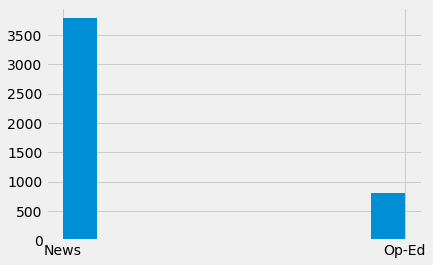

In [80]:
oped_v_news(df)

# X, y

In [138]:
#define X. X is currently pandas series of unsplit strings
X = df.article

In [139]:
#turn series into list...
corpus = list(X)

In [83]:
# define y as a series of op-ed or news
y = df.type_of_material

In [84]:
vectorize_y_ser(y)

_id
nyt://article/f5d2e4a7-f89b-54da-9985-dd5fc704a51e    0
nyt://article/0fa09b77-5faa-588f-9d4a-39a34748c7f3    0
nyt://article/6b274a69-c82b-5b68-bada-ec1467440ddf    0
nyt://article/8867f9cb-5914-5731-90b9-e1f1781fa568    0
nyt://article/fb5f6e07-033e-5618-967e-fbc1ebcfd61c    0
                                                     ..
nyt://article/2bfafff5-96ce-5dba-acf8-e2d5f8eab27e    1
nyt://article/7254685b-f45b-5165-a4a0-8aeab43d9841    0
nyt://article/78e5cf9b-da8f-5fe1-8b69-4f91d4c5e174    0
nyt://article/12aacb9c-8972-5cce-add8-c8c0cebe74e0    0
nyt://article/34f9a992-f1c9-53f7-ad81-67d9f064908e    0
Name: type_of_material, Length: 4585, dtype: int64

In [85]:
%%time
# vectorize y in to (1, 0) (op-ed, news)
y = vectorize_y_ser(y)

CPU times: user 1.93 ms, sys: 287 µs, total: 2.22 ms
Wall time: 2.03 ms


In [86]:
y.value_counts()

0    3786
1     799
Name: type_of_material, dtype: int64

In [87]:
y.shape

(4585,)

# remove stop words

# stemming/lemmatization

In [88]:
snowball = SnowballStemmer('english')
wordnet = WordNetLemmatizer()

In [89]:
# %%time
# def snowball_tokenize(doc):
#     snowball = SnowballStemmer('english')
#     return [snowball.stem(word) for word in word_tokenize(doc.lower())]

In [90]:
%%time
def wordnet_tokenize(doc):
    wordnet = WordNetLemmatizer()
    return  [wordnet.lemmatize(word) for word in word_tokenize(doc.lower())]

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 4.77 µs


# vectorizer

# WORDNET tfidf

In [91]:
import string

In [92]:
print(string.punctuation)
print('!"#$%&\'()*+—,-./:;<=>?@[\\]^_`{|}~’')

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
!"#$%&'()*+—,-./:;<=>?@[\]^_`{|}~’


In [93]:
# nytimes_quotes = "”“"
# nytimes_punctuation = "—"

In [94]:
#function that removes string.punctuation w/out the '?'
def punc_strip(document):
    for char in document:
        if char in '!"#$%&\'()*+—,-./:;<=>?@[\\]^_`{|}~’':
            document = document.replace(char, " ")
    return document

In [95]:
base_news = ['about',
 'administration',
 'after',
 'against',
 'all',
 'also',
 'american',
 'an',
 'and',
 'another',
 'any',
 'are',
 'at',
 'back',
 'be',
 'because',
 'been',
 'before',
 'being',
 'both',
 'but',
 'by',
 'called',
 'campaign',
 'can',
 'come',
 'congress',
 'could',
 'country',
 'day',
 'democrat',
 'democratic',
 'did',
 'do',
 'don',
 'down',
 'during',
 'election',
 'even',
 'federal',
 'first',
 'for',
 'former',
 'from',
 'get',
 'go',
 'going',
 'government',
 'group',
 'ha',
 'had',
 'have',
 'he',
 'him',
 'his',
 'house',
 'how',
 'if',
 'in',
 'including',
 'into',
 'is',
 'issue',
 'it',
 'just',
 'last',
 'law',
 'leader',
 'like',
 'long',
 'made',
 'make',
 'many',
 'may',
 'member',
 'month',
 'more',
 'most',
 'mr',
 'much',
 'national',
 'new',
 'no',
 'not',
 'now',
 'of',
 'office',
 'official',
 'on',
 'one',
 'only',
 'or',
 'other',
 'our',
 'out',
 'over',
 'own',
 'part',
 'party',
 'people',
 'policy',
 'political',
 'president',
 'public',
 're',
 'republican',
 'right',
 'said',
 'say',
 'senate',
 'senator',
 'she',
 'should',
 'since',
 'so',
 'some',
 'state',
 'still',
 'such',
 'take',
 'than',
 'that',
 'the',
 'their',
 'them',
 'then',
 'there',
 'these',
 'they',
 'think',
 'this',
 'those',
 'through',
 'time',
 'to',
 'trump',
 'two',
 'under',
 'united',
 'up',
 'very',
 'wa',
 'want',
 'washington',
 'way',
 'we',
 'week',
 'well',
 'were',
 'what',
 'when',
 'where',
 'whether',
 'which',
 'while',
 'white',
 'who',
 'will',
 'with',
 'work',
 'would',
 'year',
 'you']

In [96]:
names = ['donald','joseph','jr','joe']

In [97]:
stop = ['said' 'mr','our','trump','biden','america','american']

In [223]:
alphabet = ['a','b','c','d', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
stop_words = alphabet + base_news + names + stop

In [224]:
%%time
#create vectorizer

vectorizer = TfidfVectorizer(#input='content', 
#                 encoding='utf-8', 
#                 decode_error='strict', 
#                 strip_accents='ascii', 
#                 lowercase=True, 
                 preprocessor=punc_strip, 
                 tokenizer=wordnet_tokenize, 
#                 analyzer='word', 
                 stop_words=alphabet,
#                 token_pattern='(?u)\b\w\w+\b', 
#                 ngram_range=(1, 1), 
                 max_df=0.85, 
                 min_df=0.1, 
                 max_features=None, 
#                 vocabulary=None, 
#                 binary=False, 
#                 dtype=<class 'numpy.float64'>, 
#                 norm='l2', 
#                 use_idf=True, 
#                 smooth_idf=True, 
#                 sublinear_tf=False
)

CPU times: user 1.66 ms, sys: 42 µs, total: 1.7 ms
Wall time: 1.71 ms


# test, train, split

In [225]:
#test, train, split

In [226]:
%%time
#test, train, split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3438,) (1147,) (3438,) (1147,)
CPU times: user 2.53 ms, sys: 1.22 ms, total: 3.75 ms
Wall time: 3.36 ms


In [227]:
%%time
print(datetime.datetime.now())
X_train = vectorizer.fit_transform(X_train)

2021-01-09 14:29:44.896116
CPU times: user 26.4 s, sys: 82 ms, total: 26.5 s
Wall time: 26.5 s


In [228]:
%%time
print(datetime.datetime.now())
X_test = vectorizer.transform(X_test)

2021-01-09 14:30:11.411722
CPU times: user 9.05 s, sys: 18.4 ms, total: 9.07 s
Wall time: 9.07 s


In [229]:
vocab = vectorizer.vocabulary_

In [230]:
len(vocab)

929

In [231]:
X_train.shape

(3438, 929)

In [232]:
X_test.shape

(1147, 929)

# count vectorizer

In [233]:
# count_vectorizer = CountVectorizer(strip_accents='None',
#                                    lowercase=True,
#                                    tokenizer=snowball_tokenize,
#                                    stop_words='english',
#                                    max_features=None)

# balance classes

In [234]:
%%time
#balance the classes

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)

#X, y --> X_resampled, y_resampled
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))
print(rus)

[(0, 615), (1, 615)]
RandomUnderSampler(random_state=0)
CPU times: user 4.05 ms, sys: 1.49 ms, total: 5.54 ms
Wall time: 4.57 ms


# random forest classifier

In [235]:
%%time
print(datetime.datetime.now())
rf_clf = RandomForestClassifier(max_depth=2, random_state=0)

2021-01-09 14:30:20.527571
CPU times: user 426 µs, sys: 347 µs, total: 773 µs
Wall time: 508 µs


In [236]:
rf_clf.fit(X_resampled, y_resampled)
y_pred = rf_clf.predict(X_test)
y_pred.shape

(1147,)

### metrics y_pred

In [237]:
tn, fp, fn, tp = confusion_matrix(y_true = y_test, y_pred = y_pred).ravel()

In [238]:
print(y_test.shape)
print(y_pred.shape)

(1147,)
(1147,)


In [239]:
metrics_(tn, fp, fn, tp)

Accuracy: 0.95
Recall: 0.96
Precision: 0.78
TN:913 FP:50 FN:8 TP:176


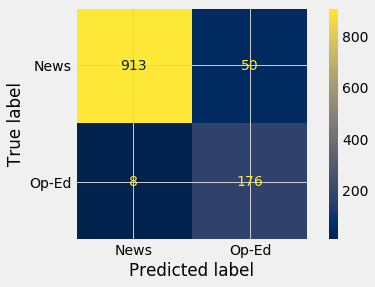

In [240]:
class_names = ["News", "Op-Ed"]
plot_confusion_matrix(estimator=rf_clf,
                      X=X_test,
                      y_true=y_test,
                      display_labels=class_names,
                      cmap='cividis')
plt.savefig('img/confusion_matrix.png');

# vectorizer parameters

In [241]:
vectorizer_parameters(vectorizer)

Number of features: 929, Numbers of stop words: 40858
analyzer: word
binary: False
decode_error: strict
dtype: <class 'numpy.float64'>
encoding: utf-8
input: content
lowercase: True
max_df: 0.85
max_features: None
min_df: 0.1
ngram_range: (1, 1)
norm: l2
preprocessor: <function punc_strip at 0x7ff19220ee60>
smooth_idf: True
stop_words: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
strip_accents: None
sublinear_tf: False
token_pattern: (?u)\b\w\w+\b
tokenizer: <function wordnet_tokenize at 0x7ff17e7c0200>
use_idf: True
vocabulary: None


# important features

### feature imporance

2021-01-09 14:30:21.060075
CPU times: user 334 ms, sys: 18.9 ms, total: 353 ms
Wall time: 345 ms


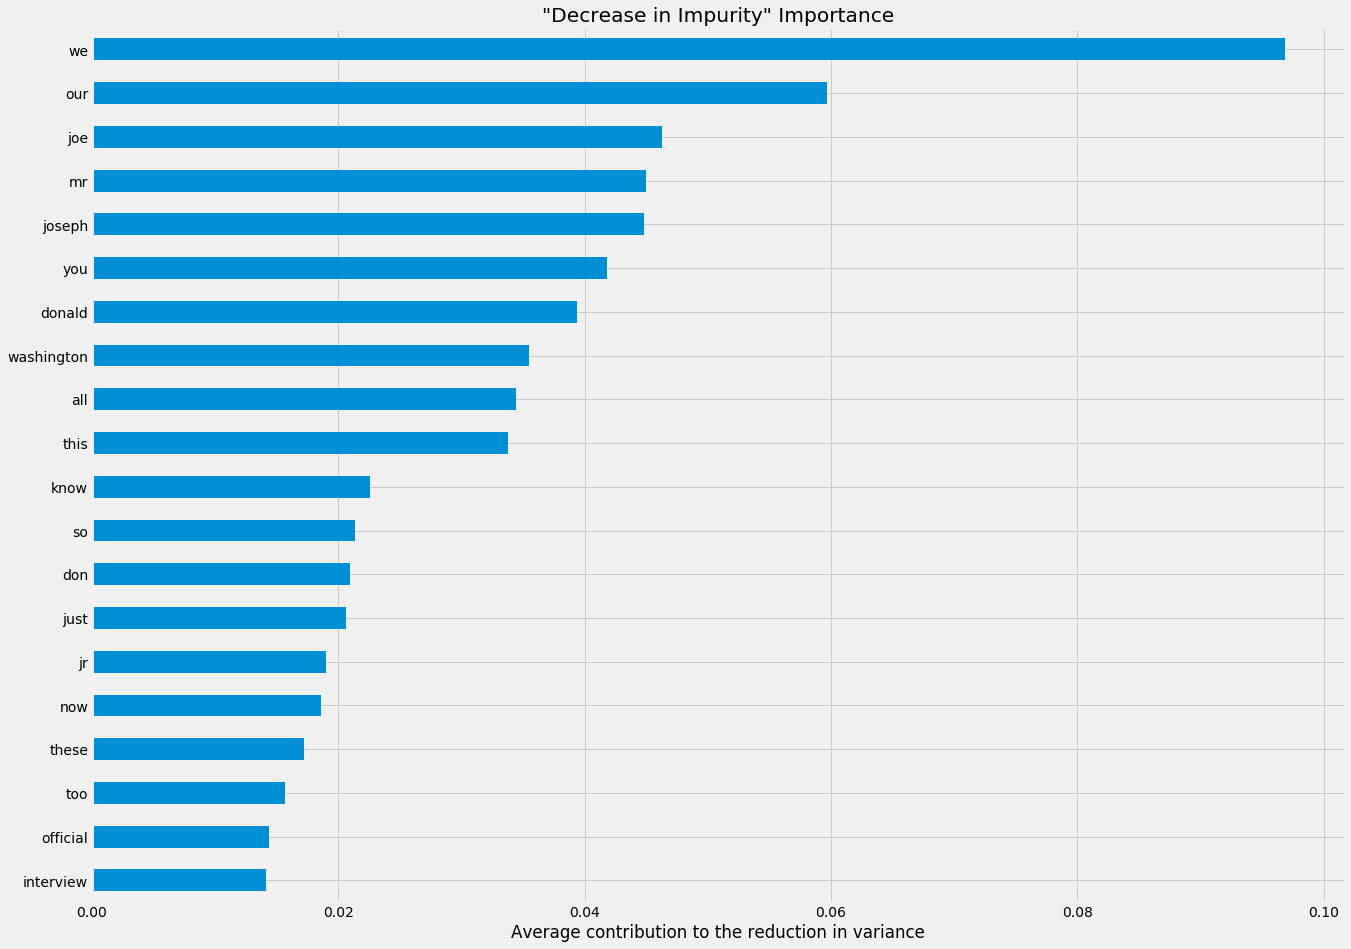

In [242]:
%%time
print(datetime.datetime.now())

feat_names = vectorizer.get_feature_names()
feature_import = rf_clf.feature_importances_

feat_scores = pd.Series(feature_import, index=feat_names)
feat_scores = feat_scores.sort_values()
ax = feat_scores[-20:].plot(kind='barh', figsize=(20,15))
ax.set_title('"Decrease in Impurity" Importance')
ax.set_xlabel('Average contribution to the reduction in variance')
plt.savefig('img/feature_imporance.png');

In [247]:
feat_scores[-50:]

or            0.004337
committee     0.004365
feel          0.004840
expected      0.005120
no            0.005292
america       0.005399
senior        0.005429
go            0.005547
much          0.005579
according     0.005772
didn          0.006095
going         0.006303
actually      0.006315
should        0.006447
very          0.007002
including     0.007123
thing         0.007302
let           0.007842
spokesman     0.007935
life          0.008084
think         0.009219
what          0.009945
month         0.010544
do            0.010775
better        0.011434
re            0.012312
if            0.012781
comment       0.013137
there         0.013450
statement     0.013709
interview     0.014168
official      0.014420
too           0.015709
these         0.017251
now           0.018580
jr            0.018994
just          0.020677
don           0.020963
so            0.021336
know          0.022566
this          0.033828
all           0.034462
washington    0.035491
donald     

### permutation importance

In [243]:
# %%time
# print(datetime.datetime.now())
# r = permutation_importance(rf_clf, X_test.toarray(), y_test, n_repeats=30, random_state=0)

In [244]:
# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{feat_names[i]:<8}"
#               f"{r.importances_mean[i]:.3f}"
#               f" +/- {r.importances_std[i]:.3f}")

In [121]:
# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{feat_names[i]:<20}")
# #               f"{r.importances_mean[i]:.3f}"
# #               f" +/- {r.importances_std[i]:.3f}")

In [122]:
feat_names

['000',
 '1',
 '10',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '200',
 '2008',
 '2009',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '22',
 '24',
 '25',
 '26',
 '3',
 '30',
 '300',
 '4',
 '40',
 '400',
 '5',
 '50',
 '500',
 '6',
 '60',
 '600',
 '7',
 '70',
 '8',
 '80',
 '9',
 '90',
 'ability',
 'able',
 'abortion',
 'above',
 'abuse',
 'accept',
 'access',
 'according',
 'account',
 'accusation',
 'accused',
 'accusing',
 'acknowledged',
 'across',
 'act',
 'acting',
 'action',
 'activist',
 'activity',
 'actually',
 'ad',
 'adam',
 'add',
 'added',
 'adding',
 'addition',
 'additional',
 'address',
 'adult',
 'advance',
 'advantage',
 'advice',
 'adviser',
 'advocacy',
 'advocate',
 'affair',
 'affect',
 'affordable',
 'african',
 'afternoon',
 'again',
 'age',
 'agency',
 'agenda',
 'agent',
 'aggressive',
 'ago',
 'agree',
 'agreed',
 'agreement',
 'ahead',
 'aid',
 'aide',
 'aimed',
 'air',
 'allegation

# make a plot

In [123]:
y

_id
nyt://article/f5d2e4a7-f89b-54da-9985-dd5fc704a51e    0
nyt://article/0fa09b77-5faa-588f-9d4a-39a34748c7f3    0
nyt://article/6b274a69-c82b-5b68-bada-ec1467440ddf    0
nyt://article/8867f9cb-5914-5731-90b9-e1f1781fa568    0
nyt://article/fb5f6e07-033e-5618-967e-fbc1ebcfd61c    0
                                                     ..
nyt://article/2bfafff5-96ce-5dba-acf8-e2d5f8eab27e    1
nyt://article/7254685b-f45b-5165-a4a0-8aeab43d9841    0
nyt://article/78e5cf9b-da8f-5fe1-8b69-4f91d4c5e174    0
nyt://article/12aacb9c-8972-5cce-add8-c8c0cebe74e0    0
nyt://article/34f9a992-f1c9-53f7-ad81-67d9f064908e    0
Name: type_of_material, Length: 4585, dtype: int64

In [136]:
min_df = np.linspace(0,.4,5)

In [137]:
min_df

array([0. , 0.1, 0.2, 0.3, 0.4])

In [148]:
corpus[0]

'On the first Monday in May, the Department of Justice headquarters in Washington was on coronavirus lockdown — or at least it appeared to be from the outside. Signs posted on the outer doors facing Constitution Avenue admonished visitors to keep out if they had symptoms of Covid-19 or had been   with it. Inside, the guards operating the X-ray machines wore masks and gloves. Across the lobby, a free-standing pump of hand sanitizer cast a cautionary shadow down empty marble halls.But as you drew closer to the fifth floor, where Attorney General William Pelham Barr works out of a suite of offices, things started to loosen up. One assistant outside his conference room wore a mask, but the other did not. In the middle of the room, with its oil paintings and vaulted ceiling, the long central table had fewer chairs than you might expect, and an appropriate distance between them. But past the next door, inside the attorney general’s smaller personal office, Barr himself was also mask-free. Tu

In [181]:
%%time
num_feat_min = []

min_df = np.linspace(0,.4,5)

for val in min_df:
    vectorizer_plot = TfidfVectorizer(preprocessor=punc_strip,
#                 tokenizer=wordnet_tokenize,
#                 stop_words=stop_words,
#                 max_df=0.95,
                 min_df=val,
                 max_features=None)
    
    vectorizer_plot.fit(corpus)
    
    features = vectorizer_plot.get_feature_names()
    stop_word = vectorizer_plot.get_stop_words()

    num_feat_min.append(len(features))

CPU times: user 22.6 s, sys: 265 ms, total: 22.8 s
Wall time: 23 s


CPU times: user 13.6 ms, sys: 2.29 ms, total: 15.9 ms
Wall time: 14.8 ms


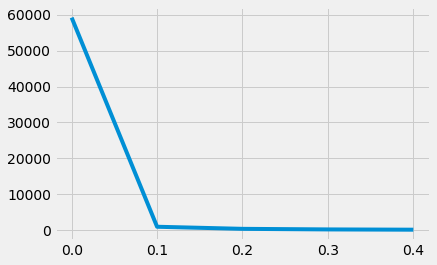

In [182]:
%%time
fig, ax = plt.subplots()
ax.plot(min_df, num_feat_min);

In [183]:
%%time
num_feat_max = []

max_df = np.linspace(.7,1,3)

for val in max_df:
    vectorizer_plot = TfidfVectorizer(preprocessor=punc_strip, 
#                 tokenizer=wordnet_tokenize, 
#                 stop_words=stop_words,
                 max_df=val,
#                 min_df=val, 
                 max_features=None)
    vectorizer_plot.fit_transform(corpus)
    features = vectorizer_plot.get_feature_names()
    stop_word = vectorizer_plot.get_stop_words()

    num_feat_max.append(len(features))

CPU times: user 15.2 s, sys: 255 ms, total: 15.5 s
Wall time: 15.8 s


CPU times: user 14.7 ms, sys: 1.51 ms, total: 16.2 ms
Wall time: 15.1 ms


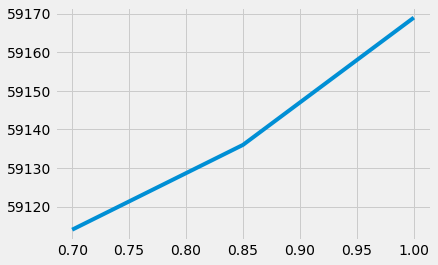

In [184]:
%%time
fig, ax = plt.subplots()
ax.plot(max_df, num_feat_max);

In [128]:
# for f in features:
#     model = RandomForestClassifier(max_features=f)
#     score = cross_val_score(model, X, y).mean()
#     print('A Random Forest Regressor with max features of: {} gets a score of {}'
#           .format(f,score))
#     scores.append(score)
    
# fig, ax = plt.subplots()
# ax.plot(features, scores)

In [ ]:
# for f in features:
#     model = RandomForestClassifier(max_features=f)
#     score = cross_val_score(model, X, y).mean()
#     print('A Random Forest Regressor with max features of: {} gets a score of {}'
#           .format(f,score))
#     scores.append(score)